In [20]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
import matplotlib.pyplot as plt

#### LSTM

In [28]:
df=pd.read_excel('./Energy.xlsx')
primary=df['Primary']
total=df['Total']
# print(total)
def timeseries_to_supervised(data, lag=1):
  df = pd.DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = pd.concat(columns, axis=1)
  df.fillna(0, inplace=True)
  return df


def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences= False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('linear'))
    # model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='mse', optimizer='rmsprop')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

def forecast_lstm(model, batch_size, X):
  X = X.reshape(1, 1, len(X))
  yhat = model.predict(X, batch_size=batch_size)
  return yhat[0,0]



raw_values=primary
supervised = timeseries_to_supervised(raw_values, 1)
supervised_values = supervised.values
# supervised_values=supervised_values[12:-12]
train, test = supervised_values[0:-12], supervised_values[-12:]
scaler, train_scaled, test_scaled = scale(train, test)

lstm_model = fit_lstm(train_scaled, 1, 300, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)



array([[-0.9291278 ],
       [ 0.2510113 ],
       [ 0.19844681],
       [ 0.10233045],
       [-0.15431845],
       [-0.4170339 ],
       [-0.66344965],
       [-0.73508406],
       [-0.72793365],
       [-0.69428384],
       [-0.55051446],
       [-0.15874898],
       [ 0.10497147],
       [ 0.22022337],
       [ 0.14848942],
       [ 0.0509609 ],
       [-0.14336026],
       [-0.4723649 ],
       [-0.65994465],
       [-0.72218   ],
       [-0.7455367 ],
       [-0.695521  ],
       [-0.49585915],
       [-0.25076306],
       [ 0.12306726],
       [ 0.18670428],
       [ 0.16236824],
       [ 0.1114983 ],
       [ 0.01142955],
       [-0.43230426],
       [-0.66168976],
       [-0.7220129 ],
       [-0.73843646],
       [-0.6945318 ],
       [-0.5576627 ],
       [-0.3452624 ],
       [ 0.11656159],
       [ 0.24112743],
       [ 0.16716892],
       [ 0.03770816],
       [-0.20993578],
       [-0.4377395 ],
       [-0.61446285],
       [-0.7052417 ],
       [-0.73639417],
       [-0

Test RMSE: 192.581


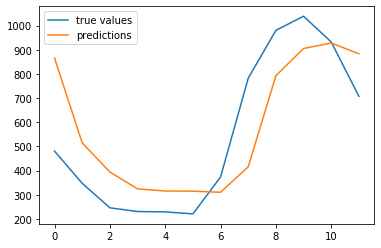

In [29]:
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    # yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    # expected = raw_values[len(train) + i]
    # print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

rmse = math.sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
expected=raw_values[-12:].values
plt.plot(expected)
plt.plot(predictions)
plt.legend(['true values','predictions'])
plt.show()

#### machine learning

(531, 12) (531, 1)
Test RMSE: 70.292


D:\software\Programming\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\Programming\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


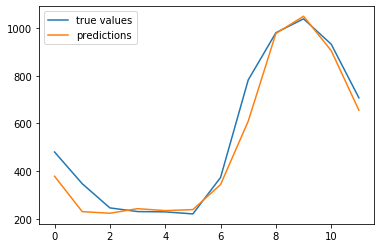

In [49]:
from sklearn.neural_network import MLPRegressor  
from sklearn.preprocessing import StandardScaler

raw_values=primary
supervised = timeseries_to_supervised(raw_values, 12)
supervised_values = supervised.values
supervised_values=supervised_values[12:-12]
train, test = supervised_values[0:-12], supervised_values[-12:]

X, y = train[:, 0:-1], train[:, -1]
scaler = StandardScaler() # 标准化转换
scaler.fit(X)  
X = scaler.transform(X)
y = np.array(y).reshape(len(y),1)
# print(X.shape,y.shape)
mdl = MLPRegressor(alpha=0.01,hidden_layer_sizes=(24, 12), solver='adam')
mdl.fit(X, y)

true=raw_values[-12:].values

# predictions = list()
X= test[:, 0:-1]
X = scaler.transform(X)
# for i in range(12):
# 
#     yhat = mdl.predict(X[i].reshape(1,12))
#     print(X[i],yhat)
#     predictions.append(yhat)
  
predictions=mdl.predict(X)
rmse = math.sqrt(mean_squared_error(true, predictions))
print('Test RMSE: %.3f' % rmse)
plt.plot(true)
plt.plot(predictions)
plt.legend(['true values','predictions'])
plt.show()

#### state space

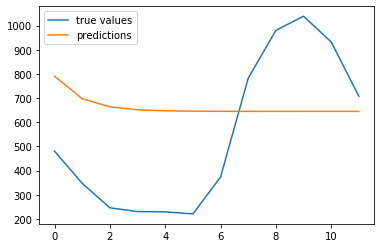

Test RMSE: 337.970


In [59]:
import scipy

def ForecastDamped(y,h):
  
    obs=len(y)
    damped=np.zeros(obs*2).reshape(obs,2)
    damped[0,0]=y[0]
  
    inn=np.zeros(obs).reshape(obs,1)
  
  
    def fmsoe(param):
        k1=abs(param[0]);k2=abs(param[1]);k3=abs(param[2])
        for t in range(1,obs) :
            inn[t]=y[t]-damped[t-1,0]-k3*damped[t-1,1]
            damped[t,0] = damped[t-1,0]+k3*damped[t-1,1]+k1*inn[t]
            damped[t,1] = k3*damped[t-1,1]+k2*inn[t]
        return sum(inn**2)/obs
  
    result=scipy.optimize.minimize(fun=fmsoe,x0=[
        np.random.random(1),np.random.random(1),np.random.random(1)])
  
    k1=abs(result.x[0])
    k2=abs(result.x[1])
    k3=abs(result.x[2])
    if(k3>1):k3=1
  
    for t in range(1,obs):
    
        inn[t]=y[t]-damped[t-1,0]-k3*damped[t-1,1]
        damped[t,0] = damped[t-1,0]+k3*damped[t-1,1]+k1*inn[t]
        damped[t,1] = k3*damped[t-1,1]+k2*inn[t]
    

  
    Forecast=np.zeros(h)
    Forecast[0]=damped[obs-1,0]+k3*damped[obs-1,1]
    for i in range(1,h):
        Forecast[i]=Forecast[i-1]+damped[obs-1,1]*k3**i
    return Forecast

y=primary.tolist()

y_h=ForecastDamped(y[:-12],12)
y_h=y_h.tolist()


plt.plot(y[-12:])
plt.plot(y_h)
plt.legend(['true values','predictions'])
plt.show()

rmse = math.sqrt(mean_squared_error(y[-12:], y_h))
print('Test RMSE: %.3f' % rmse)